In [1]:
# note that you probably need to start Sage at a directory where this is accessible
load("../../Rosa/partitionalgrep/multisetpartition_v2.py")

Loading MultiSetPartition, SetPartitionofMultiSet, MultiSetPartitions and SetPartitionsofMultiSet
BiSetPartition, BiSetPartitions, MCPartition, MCPartitions (v 6.0 date: Feb 8, 2020)
key_lex, key_rlex, key_grlex


In [5]:
def MSP_poset(lam):
    """
    Returns the poset of multiset partitions of content lam
    ordered by refinement order.

    INPUT:
    - lam -- a composition indicating the number of 1s, 2s, etc.

    EXAMPLES::
        sage: MSP_poset([2,3])
        Finite poset containing 16 elements
    """
    return Poset((MultiSetPartitions(lam),lambda x,y: y.is_coarser(x)))

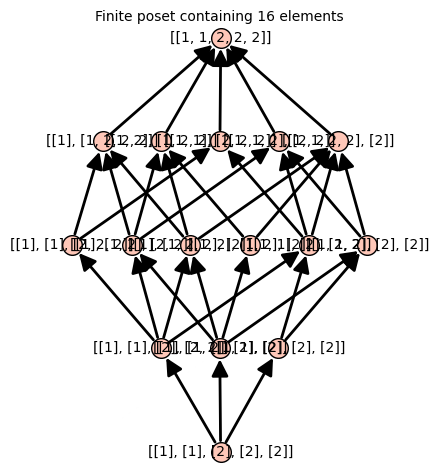

In [6]:
MSP_poset([2,3])

In [3]:
def msp_delta(msp1, msp2):
    # if msp1 covers msp2 in refinement order, then detail how msp1 and msp2 are related
    # there is a unique set S in msp2 which is the union of two sets in msp1
    """
    INPUT:
        - msp1, msp2 - two multiset partitions of the same content, msp2 covers msp1
    OUTPUT:
        - (S, [A, B]) where S is a set of msp2 and A and B are sets of msp1
        S is a union of A and B
        we add the condition that len(A) >= len(B)
        A and B are known as 'joiners' in the text below
    EXAMPLES::
        sage: msp_delta([[1,2],[1],[2]],[[1,2],[1,2]])
        ([1, 2], [[1], [2]])
        sage: msp_delta([[1,2],[2],[1]],[[1,2],[1,2]])
        ([1, 2], [[2], [1]])
        sage: msp_delta([[1,2],[2],[1,1]],[[1,2],[1,1,2]])
        ([1, 2], [[1, 1], [2]])
    """
    to_rm = [S for S in msp2]
    joiners = []
    for S in msp1:
        if S in to_rm:
            to_rm.remove(S)
        else:
            joiners.append(S)
    assert len(to_rm)==1, "there is more than one set that remains"
    assert len(joiners)==2, "there are more than two sets which were joined"
    return (to_rm[0], sorted(joiners, key=lambda x:-len(x)))
def ms_to_integer(ms):
    PS = list(primes(1,30))
    return mul(PS[a-1] for a in ms)
def locate_joiners(forest, joiners):
    #return the indices of where the sets in the joiners are in the forest
    # sort the elements of the forest whose sets are the first joiner and take the smallest
    # then sort the elements of the forest who ele
    """
    The indices of the trees in the forest that will be joined

    INPUT:
        - forest -- a forest of trees
        - joiners -- a pair of multisets to join together

    EXAMPLES::
        sage: locate_joiners([[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2, 2], (2, 3), [(2, 4)]]],[[1], [1]])
        (0, 1)
        sage: locate_joiners([[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2, 2], (2, 3), [(2, 4)]]],[[2, 2], [1]])
        (0, 3)
    """
    r1 = sorted([r for r in range(len(forest)) if forest[r][0]==joiners[0]],key=lambda r: index_tree(forest[r]))[0]
    r2 = sorted([r for r in range(len(forest)) if forest[r][0]==joiners[1] and r!=r1],key=lambda r: index_tree(forest[r]))[0]
    if index_tree(forest[r1])<index_tree(forest[r2]):
        return (r1,r2)
    else:
        return (r2,r1)
def chain_to_labels(c, verbose=False):
    # create the labeling from the chain.
    # note c[0] should consist of a bunch of sets of size 1
    # c is a "chain"
    """
    Given a chain c, return a list of labels of the chain by builing the forest
    and creating a list of CR_label(v1,v2) where v1 and v2 are trees in the forest
    that are joined together.

    INPUT:
        - c -- a chain of multisets given as a list of covers in the multiset partition poset
        - verbose -- an optional argument (default: False) that will print out the steps in
            in the forest as well
    
    This function depends on the function CR_labels.

    EXAMPLES::
        sage: chain_to_labels([[[1], [1], [1], [2], [2]], [[1], [1], [1, 2], [2]], [[1], [1, 1, 2], [2]]])
        [(1, 2, 0, 3), (1, 1, 0, 1)]
    """
    forest = [[[c[0][i][0]],(c[0][i][0],i)] for i in range(len(c[0]))] # starting forest
    # consists of list of [multiset, head, children]
    labels = []
    for j in range(1,len(c)):
        # for each subsequent entry find the smallest two sets whose union is the entry in c
        (S, joiners) = msp_delta(c[j-1],c[j])
        if verbose:
            print("step %s forest:"%j, forest, " joiners :", joiners)
        (r1,r2) = locate_joiners(forest, joiners)
        v1 = forest[r1]
        v2 = forest[r2]
        forest.remove(v1)
        forest.remove(v2)
        forest.append([sorted(v1[0]+v2[0])]+v1[1:]+[v2[1:]])
        labels.append(CR_label(v1,v2))
    # Note that in the end we throw away the tree that we end up with
    return labels
def chain_string(nc,lc):
    """
    return a string representing the labeled chain "c1-label->c2"
    multisets are printed using compact notation

    INPUT:
        - nc -- chain of multisets
        - lc -- labels of the edges of the chain

    EXAMPLES::
        sage: c = [[[1], [1], [1], [2], [2]], [[1], [1], [1, 2], [2]], [[1], [1, 1, 2], [2]]]
        ....: chain_string([MultisetPartition(p) for p in c], [(1, 2, 0, 3), (1, 1, 0, 1)])
        '{1|1|1|2|2}-(1, 2, 0, 3)->{1|1|12|2}-(1, 1, 0, 1)->{1|112|2}'
    """
    outstr = nc[0]._repr_pp_short()
    for i in range(len(lc)):
        outstr += "-"+str(lc[i])+"->"+nc[i+1]._repr_pp_short()
    return outstr
def check_increasing_cond(pc, top_elt, P, verbose=False):
    # pc should be a non-empty partial chain with last element bottom_elt
    """
    Check that a chain satisfies the increasing label condition
    Notice that currently I only check using the built in <= order,
    but this might eventually be modified so that different orders can be used.

    INPUT:
        - pc -- a partial saturated chain of the poset that goes from [0, bot_elt]
        - top_elt -- the top element of the interval to check
        - P -- the poset of multiset partitions

    EXAMPLES::
        sage: M32 = MSP_poset([3,2])
        sage: c = [[[1], [1], [1], [2], [2]], [[1], [1], [1], [2, 2]]]
        sage: check_increasing_cond([MultisetPartition(p) for p in c], MultisetPartition([[1, 1], [1, 2, 2]]), M32)
        True
        sage: c = [[[1], [1], [1], [2], [2]], [[1], [1], [1, 2], [2]]] 
        sage: check_increasing_cond([MultisetPartition(p) for p in c], MultisetPartition([[1, 1, 2], [1, 2]]), M32)
        False
    """
    bot_elt = pc[-1]
    PP = Poset((P.interval(bot_elt, top_elt), P.le)) # interval as a poset
    inc_chains = []
    for c in PP.maximal_chains():
        nc = pc + c[1:] # this chain completes pc and then goes from bot_elt to top_elt
        if verbose:
            print("chain ",nc)
        Lc = chain_to_labels(nc, verbose)
        if verbose:
            print("checking ",chain_string(nc,Lc))
        if all(Lc[j]<=Lc[j+1] for j in range(len(pc)-1, len(nc)-2)):
            inc_chains.append(nc)
    return len(inc_chains)==1
def check_intervals(P, verbose=False):
    """
    Check that each of the intervals satisfy the check_increasing_cond
    run over all elements in the poset and over all maximal chains from 0 -> p
    then run over all top_elt that lies above p
    check the increasing chain condition on each interval from p -> top_elt
    INPUT:
        - P -- a multiset partition poset
    EXAMPLES::
        sage: check_intervals(MSP_poset([3,2]))
        BROKEN CONDITION : chain =  [[[1], [1], [1], [2], [2]], [[1], [1], [1, 2], [2]]]  to interval top =  [[1, 1, 2], [1, 2]]
        sage: check_intervals(MSP_poset([3,1,1]))

    """
    zro = P.minimal_elements()[0]
    one = P.maximal_elements()[0]
    for p in P:
        for c in Poset((P.interval(zro,p), P.le)).maximal_chains():
            for top_elt in P.interval(p,one):
                if verbose:
                    print("\nin check_intervals p = ", p," chain 0 -> p =", c, " interval p -> ", top_elt)
                if not check_increasing_cond(c, top_elt, P, verbose):
                    print("BROKEN CONDITION : chain = ",c," to interval top = ", top_elt)
"""
For each chain c, we create a forest
c[0] is the finest multiset partition
EXAMPLE:
[[[1], [1], [1], [2], [2]], [[1], [1], [1, 2], [2]], [[1], [1], [1, 2, 2]], [[1], [1, 1, 2, 2]]]

The forest will be a list of trees each with one element.
Each tree represents one multiset which we call the content.
[content(T), root, child_1, ..., child_k]
The children are only the vertices (they do not have a content component)
the vertex is a pair (label, index)

step 1 forest: [[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2], (2, 3)], [[2], (2, 4)]]  joiners : [[1], [2]]
step 2 forest: [[[1], (1, 1)], [[1], (1, 2)], [[2], (2, 4)], [[1, 2], (1, 0), [(2, 3)]]]  joiners : [[1, 2], [2]]
step 3 forest: [[[1], (1, 1)], [[1], (1, 2)], [[1, 2, 2], (1, 0), [(2, 3)], [(2, 4)]]]  joiners : [[1, 2, 2], [1]]
"""
def root_tree(T):
    """
    The root of the tree is the label of the root of of the tree 
    """
    return T[1][0]
def index_tree(T):
    """
    The index of the tree is the index of the root of of the tree 
    """
    return T[1][1]
def content_tree(T):
    """
    The content of the tree is the multiset of the tree 
    """
    return T[0]
def content_trees(T1,T2):
    """
    The content of two trees is the union of the contents of T1 and T2
    """
    return sorted(T1[0]+T2[0])
def content_trees_2(T1,T2):
    """
    When you want to sort the content not by lex order but by
    the numbers of 1s and 2s instead
    """
    return tuple([(T1[0]+T2[0]).count(i+1) for i in range(max(T1[0]+T2[0]))])
def rec_weight(T):
    if len(T)==1:
        return 0
    else:
        return sum(rec_weight(st) for st in T[1:]) + sum(size(st) for st in T[1:])
def size(T):
    """
    the size of a tree is 1 if the tree has just a root, otherwise it is
    1 + the sum of the sizes of the children of the root.
    """
    if len(T)==1:
        return 1
    else:
        return 1+sum(size(st) for st in T[1:])
def weight_tree(T):
    rw = rec_weight(T[1:]) # got to remove the tree content which is at the head of the tree
    return rw
def CR_label_old(T1,T2):
    """
    The CR-label between T1 and T2
    """
    return (root_tree(T1),root_tree(T2),index_tree(T1),index_tree(T2))
def CR_label(T1,T2):
    """
    The CR-label between T1 and T2
    """
    return (index_tree(T1),min(ms_to_integer(content_tree(T1)),ms_to_integer(content_tree(T2))))

In [58]:
P=MSP_poset([3,1])
check_intervals(P)

BROKEN CONDITION : chain =  [[[1], [1], [1], [2]]]  to interval top =  [[1], [1, 1, 2]]
BROKEN CONDITION : chain =  [[[1], [1], [1], [2]]]  to interval top =  [[1, 1], [1, 2]]
BROKEN CONDITION : chain =  [[[1], [1], [1], [2]]]  to interval top =  [[1, 1, 1, 2]]


In [59]:
for c in P.maximal_chains():
    print("chain ",c)
    print(chain_to_labels(c, True))

chain  [[[1], [1], [1], [2]], [[1], [1], [1, 2]], [[1], [1, 1, 2]], [[1, 1, 1, 2]]]
step 1 forest: [[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2], (2, 3)]]  joiners : [[1], [2]]
step 2 forest: [[[1], (1, 1)], [[1], (1, 2)], [[1, 2], (1, 0), [(2, 3)]]]  joiners : [[1, 2], [1]]
step 3 forest: [[[1], (1, 2)], [[1, 1, 2], (1, 0), [(2, 3)], [(1, 1)]]]  joiners : [[1, 1, 2], [1]]
[(0, 2), (0, 2), (0, 2)]
chain  [[[1], [1], [1], [2]], [[1], [1], [1, 2]], [[1, 1], [1, 2]], [[1, 1, 1, 2]]]
step 1 forest: [[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2], (2, 3)]]  joiners : [[1], [2]]
step 2 forest: [[[1], (1, 1)], [[1], (1, 2)], [[1, 2], (1, 0), [(2, 3)]]]  joiners : [[1], [1]]
step 3 forest: [[[1, 2], (1, 0), [(2, 3)]], [[1, 1], (1, 1), [(1, 2)]]]  joiners : [[1, 1], [1, 2]]
[(0, 2), (1, 2), (0, 4)]
chain  [[[1], [1], [1], [2]], [[1], [1, 1], [2]], [[1], [1, 1, 2]], [[1, 1, 1, 2]]]
step 1 forest: [[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2], (2, 3)]]  joiners : [[1], [1]]
step 2 fo

In [58]:
check_intervals(P,True)


in check_intervals p =  [[1], [1], [1], [2], [2]]  chain 0 -> p = [[[1], [1], [1], [2], [2]]]  interval p ->  [[1], [1], [1], [2], [2]]
chain  [[[1], [1], [1], [2], [2]]]
checking  {1|1|1|2|2}

in check_intervals p =  [[1], [1], [1], [2], [2]]  chain 0 -> p = [[[1], [1], [1], [2], [2]]]  interval p ->  [[1], [1], [1], [2, 2]]
chain  [[[1], [1], [1], [2], [2]], [[1], [1], [1], [2, 2]]]
step 1 forest: [[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2], (2, 3)], [[2], (2, 4)]]  joiners : [[2], [2]]
checking  {1|1|1|2|2}-(2, 2, 3, 4)->{1|1|1|22}

in check_intervals p =  [[1], [1], [1], [2], [2]]  chain 0 -> p = [[[1], [1], [1], [2], [2]]]  interval p ->  [[1], [1], [1, 2], [2]]
chain  [[[1], [1], [1], [2], [2]], [[1], [1], [1, 2], [2]]]
step 1 forest: [[[1], (1, 0)], [[1], (1, 1)], [[1], (1, 2)], [[2], (2, 3)], [[2], (2, 4)]]  joiners : [[1], [2]]
checking  {1|1|1|2|2}-(1, 2, 0, 3)->{1|1|12|2}

in check_intervals p =  [[1], [1], [1], [2], [2]]  chain 0 -> p = [[[1], [1], [1], [2], [2]]]  